# iGEM 2021
## Saccharomyces cerevisiae GSM analysis
#### Groningen and DTU BioBuilders teams collaboration

In [1]:
# import necessary libraries, especially cobra package, specialized on GSM
import numpy as np
import matplotlib.pyplot as plt
import cobra

# model originally from:
# Mo ML, Palsson BO, Herrgård MJ. Connecting extracellular metabolomic measurements to intracellular flux states in yeast. BMC Syst Biol. 2009 Mar 25;3:37. doi: 10.1186/1752-0509-3-37. PMID: 19321003; PMCID: PMC2679711.

# load model
saccerv = cobra.io.read_sbml_model("./data/iMM904.xml")

First of all, we will do a general analysis of some basic concepts from the model. This is something that could also perfectly be done by manual checking on the sbml file, but cobrapy allows some very simple funcionalities.

A very important thing on GSM is to keep track on where in the cells the different reactions are ocurring, and that is why is nice to know which compartments are defined in the model and how are they referred as.

In [2]:
saccerv.compartments

{'c': 'cytosol',
 'e': 'extracellular space',
 'm': 'mitochondria',
 'x': 'peroxisome/glyoxysome',
 'r': 'endoplasmic reticulum',
 'v': 'vacuole',
 'g': 'golgi apparatus',
 'n': 'nucleus'}

After that, is nice to see which conditions are defined for our medium. Usually GSM is based on constrainin reactions with your knowledge from literature or experiments done, and for cases you have no data, you just do not include any constrain, allowing a complete freedom on that dimension/reaction.

This is what happens in the next part, we see the medium comes defined by some exchange reactions ("EX_"), where the limits of the cell uptake for different metabolites are placed.

In [3]:
# It is seen that the two bounds are constrained for 'EX_glc__D_e' and 'EX_o2_e', so glucose and oxygen, respectively.
saccerv.medium

{'EX_fe2_e': 999999.0,
 'EX_glc__D_e': 10.0,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_so4_e': 999999.0,
 'EX_nh4_e': 999999.0,
 'EX_o2_e': 2.0,
 'EX_pi_e': 999999.0}

In [4]:
# Let's try first to check the glucose reaction, as we see that the glucose uptake is limited to 10 mmol/gDW h^-1, which is
# the usual units for GSM
saccerv.reactions.EX_glc__D_e

<Reaction EX_glc__D_e at 0x7f6c4e27bc40>

In [5]:
# but this is not the reaction that introduces glucose to the cell, it is just the external exchange for placing the constrains,
# so let's find in which reactions is this metabolite involved
saccerv.metabolites.glc__D_e

<Metabolite glc__D_e at 0x7f6c4ea12c40>

In [6]:
# as seen in the previous summary, glc__D_e metabolite is involved in 4 reactions, being GLCt1 the one for uptake
saccerv.reactions.GLCt1

<Reaction GLCt1 at 0x7f6c4e07fd90>

And the same would go with oxygen, limited to an uptake of $2 mmol/gDW h^{-1}$

Now, we analyze what this model is trying to optimize by default (meaning that cobrapy allows the user to choose any reaction to optimize).

In [7]:
saccerv.summary()

As usual, by default it optimizes biomass production, and here we can see a summary where after the optimization, a biomass production of $0.288 mmol/gDW h^{-1}$ is obtained. Besides, it can be seen the top 5 uptake and secretion metabolites with their flux.

But now, let's go to the fun part and include our synthetic biology, for the production of our introduced genes. In this case, we will try introducing one of each of the genes at a time to produce the different amylases. This requires to specify the expression of dna, rna and amino acid sequence --> protein.

As the sequences are long, we calculate the stoichiometry with a script which is on the github repo and imported here
based on the logic behind introduction of heterologous protein production in the paper:
*Irani ZA, Kerkhoven EJ, Shojaosadati SA, Nielsen J (2016) Genome-scale metabolic model of Pichia pastoris with native and humanized glycosylation of recombinant proteins. Biotechnol Bioeng 113:961–969. doi: 10.1002/bit.25863.*

In [8]:
# import our code with one method for transcription and one for introduction of correct stoichiometry into the model for protein expression 
import stoichiometry_groningen as stoich 
from Groningen_sequences import * # all sequences for dna and protein are saved in one python file as strings

In [9]:
# the transcription method allows transcription when a DNA sequence is introduced as parameter
A_oryzae_rna = stoich.transcription(A_oryzae_dna)
B_amyloliquenifaciens_rna = stoich.transcription(B_amyloliquenifaciens_dna)
B_licheniformis_rna = stoich.transcription(B_licheniformis_dna)
B_Subtilis_rna = stoich.transcription(B_Subtilis_dna)

In [10]:
def add_protein_reaction(model, reaction, lb, ub, seq, seq_type, protein_name = 'amylase'):
    
    stoichiometry = stoich.get_stoichiometry(seq, seq_type, protein_name)
    
    
    reaction = cobra.Reaction(
                reaction,
                name = reaction,
                lower_bound = lb,
                upper_bound = ub
        )
    
    for molecule in stoichiometry:
        reaction.add_metabolites(
            {
                getattr(model.metabolites, molecule): stoichiometry[molecule] 
            }
        )
    
    model.add_reactions([reaction])

# and after that we need to remove them before including the ones for new organism --> create a function so we just call it
def remove_amylase(model):
    model.remove_reactions([model.reactions.amylase_DNA_reaction,
                            model.reactions.amylase_RNA_reaction,
                            model.reactions.amylase_AA_reaction])

In [11]:
# before introducing reactions into the model, we need to define the metabolites involved
# in this case, as for all cases will be amylase, just changing the organism from which we take the gene, we will use a general name

amylase_DNA = cobra.Metabolite(
    'amylase_DNA',
    name='amylase_DNA',
    compartment='c')

amylase_RNA = cobra.Metabolite(
    'amylase_RNA',
    name='amylase_RNA',
    compartment='c')

amylase_AA = cobra.Metabolite(
    'amylase_AA',
    name='amylase_AA',
    compartment='c')

saccerv.add_metabolites([amylase_DNA,
                       amylase_RNA,
                       amylase_AA])

### A. Oryzae

In [15]:
# 0.0125-(0.0125*(1-0.5)^(1/5)) this is the amount of protein degraded in one hour at a typical half-life of 5 hours
# starting at 0.0125g/gDW = 2.5% of total protein as about 50% of gDW is protein
#
# higher values than 0.00065 yield an infeasible solution, so we take that as it is quite a low amount already
# using a strong promoter

add_protein_reaction(saccerv, 'amylase_DNA_reaction', -1000, 1000, A_oryzae_dna, 'dna', 'amylase')
add_protein_reaction(saccerv, 'amylase_RNA_reaction', -1000, 1000, A_oryzae_rna, 'rna', 'amylase')
add_protein_reaction(saccerv, 'amylase_AA_reaction', 0.00065, 0.00065, A_oryzae_protein, 'aa', 'amylase')

Ignoring reaction 'amylase_DNA_reaction' since it already exists.
Ignoring reaction 'amylase_RNA_reaction' since it already exists.
Ignoring reaction 'amylase_AA_reaction' since it already exists.


In [16]:
cobra.io.write_sbml_model(saccerv, "./data/test.xml")

In [17]:
A_oryzae = saccerv.optimize().objective_value
saccerv.summary()

In [18]:
remove_amylase(saccerv)

### B. Amyloliquenifaciens

In [19]:
add_protein_reaction(saccerv, 'amylase_DNA_reaction', -1000, 1000, B_amyloliquenifaciens_dna, 'dna', 'amylase')
add_protein_reaction(saccerv, 'amylase_RNA_reaction', -1000, 1000, B_amyloliquenifaciens_rna, 'rna', 'amylase')
add_protein_reaction(saccerv, 'amylase_AA_reaction', 0.00065, 0.00065, B_amyloliquenifaciens_protein, 'aa', 'amylase')
B_amyloliquenifaciens = saccerv.optimize().objective_value
saccerv.summary()

In [20]:
remove_amylase(saccerv)

### B. Licheniformis

In [21]:
add_protein_reaction(saccerv, 'amylase_DNA_reaction', -1000, 1000, B_licheniformis_dna, 'dna', 'amylase')
add_protein_reaction(saccerv, 'amylase_RNA_reaction', -1000, 1000, B_licheniformis_rna, 'rna', 'amylase')
add_protein_reaction(saccerv, 'amylase_AA_reaction', 0.00065, 0.00065, B_licheniformis_protein, 'aa', 'amylase')
B_licheniformis = saccerv.optimize().objective_value
saccerv.summary()

In [22]:
remove_amylase(saccerv)

### B. Subtilis

In [23]:
add_protein_reaction(saccerv, 'amylase_DNA_reaction', 0, 100, B_Subtilis_dna, 'dna', 'amylase')
add_protein_reaction(saccerv, 'amylase_RNA_reaction', 0, 100, B_Subtilis_rna, 'rna', 'amylase')
add_protein_reaction(saccerv, 'amylase_AA_reaction', 0.00065, 0.00065, B_subtilis_protein, 'aa', 'amylase')
B_Subtilis = saccerv.optimize().objective_value
saccerv.summary()

In [24]:
# we create a function to see how growth is influenced by oxygen supply
# precision is how many values from 0 to the max (here max_ox) are evaluated
def plot(model, precision, max_ox):
    plot = list()
    oxygen_vec = np.linspace(0,max_ox,precision)
    for count_ox, oxygen in enumerate(oxygen_vec):
        model.reactions.EX_o2_e.bounds = -oxygen, 999999
        result = model.optimize().objective_value
        if result < 0: 
            result = 0
        plot.append(result)

    plt.plot(oxygen_vec,plot)

    plt.title("Growth for different O2 supply")
    plt.ylabel("Biomass")
    plt.xlabel("Oxygen uptake")

    return plot

[0.0,
 0.23149373377919558,
 0.2533692564098665,
 0.2721282022409014,
 0.28803862870486174,
 0.30373719465373517,
 0.3194357606026084,
 0.33513432655148184,
 0.35083289250035543,
 0.3665314584492286,
 0.3822300243981021,
 0.39792859034697553,
 0.413627156295849,
 0.4293257222447224,
 0.44502428819359546,
 0.46072285414246944,
 0.4764214200913431,
 0.49211998604021623,
 0.5078185519890893,
 0.5235171179379627,
 0.5392156838868367,
 0.5549142498357094,
 0.5706128157845829,
 0.5863113817334563,
 0.6020099476823288,
 0.6177085136312033,
 0.6334070795800764,
 0.649080362592898,
 0.6647080997627063,
 0.6802492980487514,
 0.6957024723755909,
 0.7111556467024296,
 0.7266088210292686,
 0.7420619953561076,
 0.7575151696829464,
 0.7729683440097863,
 0.7884215183366251,
 0.8038746926634646,
 0.8193278669903028,
 0.8347810413171426,
 0.8502342156439814,
 0.8656873899708205,
 0.8811405642976597,
 0.8965937386244984,
 0.912046912951338,
 0.9275000872781771,
 0.9429532616050158,
 0.9584064359318553,
 

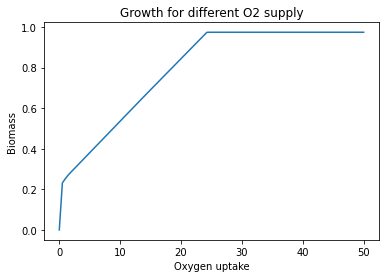

In [25]:
plot(saccerv,100,50)